In [114]:
from mplsoccer import Pitch, VerticalPitch
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt 
import ternary 
import sqlite3
from adjustText import adjust_text
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

In [2]:
query = """
SELECT
  TeamId,
  teams.team as team,
  PlayerId,
  players.player as Player,
  X,
  Y,
  Type,
  OutcomeType,
  Qualifiers,
  SatisfiedEventsTypes,
  PassEndX,
  PassEndY,
  Zone,
  Length,
  Angle,
FROM(
    SELECT
        TeamId,
  PlayerId,
  X,
  Y,
  Type,
  OutcomeType,
  Qualifiers,
  SatisfiedEventsTypes,
  PassEndX,
  PassEndY,
  Zone,
  Length,
  Angle,
  FROM
    `soccer-analytics-344915.Event_Data.EPL_2022` UNION ALL
    SELECT
  TeamId,
  PlayerId,
  X,
  Y,
  Type,
  OutcomeType,
  Qualifiers,
  SatisfiedEventsTypes,
  PassEndX,
  PassEndY,
  Zone,
  Length,
  Angle,
  FROM
    `soccer-analytics-344915.Event_Data.Bundesliga_2022` UNION ALL
    SELECT
        TeamId,
  PlayerId,
  X,
  Y,
  Type,
  OutcomeType,
  Qualifiers,
  SatisfiedEventsTypes,
  PassEndX,
  PassEndY,
  Zone,
  Length,
  Angle,
  FROM
    `soccer-analytics-344915.Event_Data.La_Liga_2022` UNION ALL
    SELECT
        TeamId,
  PlayerId,
  X,
  Y,
  Type,
  OutcomeType,
  Qualifiers,
  SatisfiedEventsTypes,
  PassEndX,
  PassEndY,
  Zone,
  Length,
  Angle,
  FROM
    `soccer-analytics-344915.Event_Data.Ligue_1_2022` UNION ALL
    SELECT
        TeamId,
  PlayerId,
  X,
  Y,
  Type,
  OutcomeType,
  Qualifiers,
  SatisfiedEventsTypes,
  PassEndX,
  PassEndY,
  Zone,
  Length,
  Angle,
  FROM
    `soccer-analytics-344915.Event_Data.Serie_A_2022`
  ) as data
LEFT JOIN 
  `soccer-analytics-344915.Lookup_Tables.Players` as players ON data.PlayerId = players.id
LEFT JOIN 
  `soccer-analytics-344915.Lookup_Tables.Teams` as teams ON data.TeamId = teams.id
WHERE
  Type = 'Pass'
  AND OutcomeType = TRUE
  AND PassEndX >= 83
  AND PassEndY <= 79
  AND PassEndY >= 21
"""
df = pd.read_gbq(query)

In [71]:
conn = sqlite3.connect(r"C:\Users\limwe\OneDrive\Documents\Computing Projects\Sports Analytics\Data\soccer_data.db")
xg_data = pd.read_sql('SELECT Squad, xG FROM Squad_Data',conn)

In [4]:
# df = pd.read_csv('backup.csv')
to_remove = [5,10,20,35,47,62]
def remove_set_piece(row):
    tmp = np.in1d(to_remove,row['Qualifiers'])
    if True in tmp:
        return 
    else:
        return 1 #means not a set piece
def key_pass(row):
    keypass= [26,27] 
    tmp = np.in1d(keypass,row['Qualifiers'])
    if True in tmp:
        return 
    else:
        return 1

df['setpiece'] = df.apply(lambda x:remove_set_piece(x),axis=1)
df = df.dropna(subset='setpiece')
df['keypass'] = df.apply(lambda x:key_pass(x),axis=1)

In [5]:
def get_types(row):
    if (row['X'] < 83) and (row['Y'] > 21) and (row['Y'] <80): 
        return 'Central'
    # elif ((row['X'] > 94.2) and (row['Y'] > 63)) or ((row['X'] > 94.2) and (row['Y'] < 36.5)) and (row['Y'] < 98) or (row['Y'] > 1) and (row['PassEndX']< 94.2):
    elif (row['X'] > 94.2) and (row['PassEndX']< 94.2) and (((row['Y'] > 63) and row['Y']<90) or ((row['Y'] < 36.5) and row['Y']>10)):
        return 'Cutback'
    elif(row['Y'] <= 21) or (row['Y'] >= 80): 
        return 'Cross'
    else:
        return 
df['Cat'] = df.apply(lambda x:get_types(x),axis=1)
df = df[df['Length'] > 5]
df = df[df['X'] > 60].dropna(subset=['Cat','keypass']).drop(['Qualifiers','SatisfiedEventsTypes'],axis=1).drop_duplicates()

In [6]:
# pitch = Pitch(pitch_type='opta', axis=True, label=True,figsize=(20,20))  # for checking coordinates 
# fig, ax = pitch.draw()
# fig.set_size_inches(20, 10)
# tmp = df[(df['Cat'] == 'Central') & (df['team'] == 'Wolves')]
# # pitch.arrows(tmp['X'],tmp['Y'],tmp['PassEndX'],tmp['PassEndY'],ax=ax)
# ax.scatter(tmp['PassEndX'],tmp['PassEndY'])


In [35]:
working_df = df.groupby(['team','Cat']).size().unstack(level=1)
working_df['total'] = working_df.sum(axis=1)
for col in ['Central', 'Cross', 'Cutback']:
    working_df[col + '%'] = working_df[col]/working_df['total'] *100
working_df = working_df.reset_index()
working_df.index.name = None


In [98]:
final = pd.DataFrame()
final['team'] = working_df['team']
for col in ['Central%','Cross%','Cutback%']:
    final[col] = working_df[col].rank(pct=True)*100
for col in ['Central%','Cross%','Cutback%']:
    final[col[:-1]] = final[col] * 100 / final[['Central%','Cross%','Cutback%']].sum(axis=1) #normalize
final = final.merge(xg_data,how='left',left_on='team',right_on='Squad')
to_label=final.sort_values('xG',ascending=False)

In [213]:
def draw_center(ax):
    pitch = VerticalPitch(half=True,pitch_type='opta',figsize=(20,20),pad_bottom=-20)  # for checking coordinates 
    pitch.draw(ax=ax)
    rect = patches.Rectangle((79,72),-57.8,11,facecolor='white',edgecolor='black')
    ax.add_patch(rect)
    ax.arrow(30,77,10,12,head_width = 1)
    ax.arrow(70,77,-10,12,head_width = 1)
    return ax
def draw_cutback(ax):
    pitch = VerticalPitch(half=True,pitch_type='opta',figsize=(20,20),pad_bottom=-20)  # for checking coordinates 
    pitch.draw(ax=ax)
    rect = patches.Rectangle((36.1,94.2),-30,5.8,facecolor='white',edgecolor='black')
    ax.add_patch(rect)
    rect = patches.Rectangle((64,94.2),30,5.8,facecolor='white',edgecolor='black')
    ax.add_patch(rect)
    ax.arrow(25,96,10,-5,head_width = 1)
    ax.arrow(75,96,-10,-5,head_width = 1)
    return ax
def draw_cross(ax):
    pitch = VerticalPitch(half=True,pitch_type='opta',figsize=(20,20),pad_bottom=-20)  # for checking coordinates 
    pitch.draw(ax=ax)
    rect = patches.Rectangle((20.8,70),-20,30,facecolor='white',edgecolor='black')
    ax.add_patch(rect)
    rect = patches.Rectangle((79.9,70),20,30,facecolor='white',edgecolor='black')
    ax.add_patch(rect)
    ax.arrow(5,80,28,8,head_width = 1)
    ax.arrow(95,80,-28,8,head_width = 1)
    return ax

In [ ]:

corner_color = 'black'
corner_size=15
fig, tax = ternary.figure(scale=100)
fig.set_size_inches(20,16)
tax.scatter(final[['Central','Cross','Cutback']].values)
names = []
for i,txt in enumerate(to_label['team'].tolist()):
    x = ternary.project_point((to_label['Central'].iloc[i],to_label['Cross'].iloc[i],to_label['Cutback'].iloc[i]))[0]
    y = ternary.project_point((to_label['Central'].iloc[i],to_label['Cross'].iloc[i],to_label['Cutback'].iloc[i]))[1]
    names.append(plt.text(x,y,txt,ha='center'))
tax.right_corner_label('Central Passes',position=(0.97,0.11),c=corner_color,fontsize= corner_size)
tax.top_corner_label('Crosses',offset=0.15,c=corner_color,fontsize= corner_size)
tax.left_corner_label('Cutbacks',position=(-0.07,0.11),c=corner_color,fontsize= corner_size)
# adjust_text(names,arrowprops=dict(arrowstyle="-", color='k', lw=0.5))


(-0.05, 1.05, -0.1, 0.9)

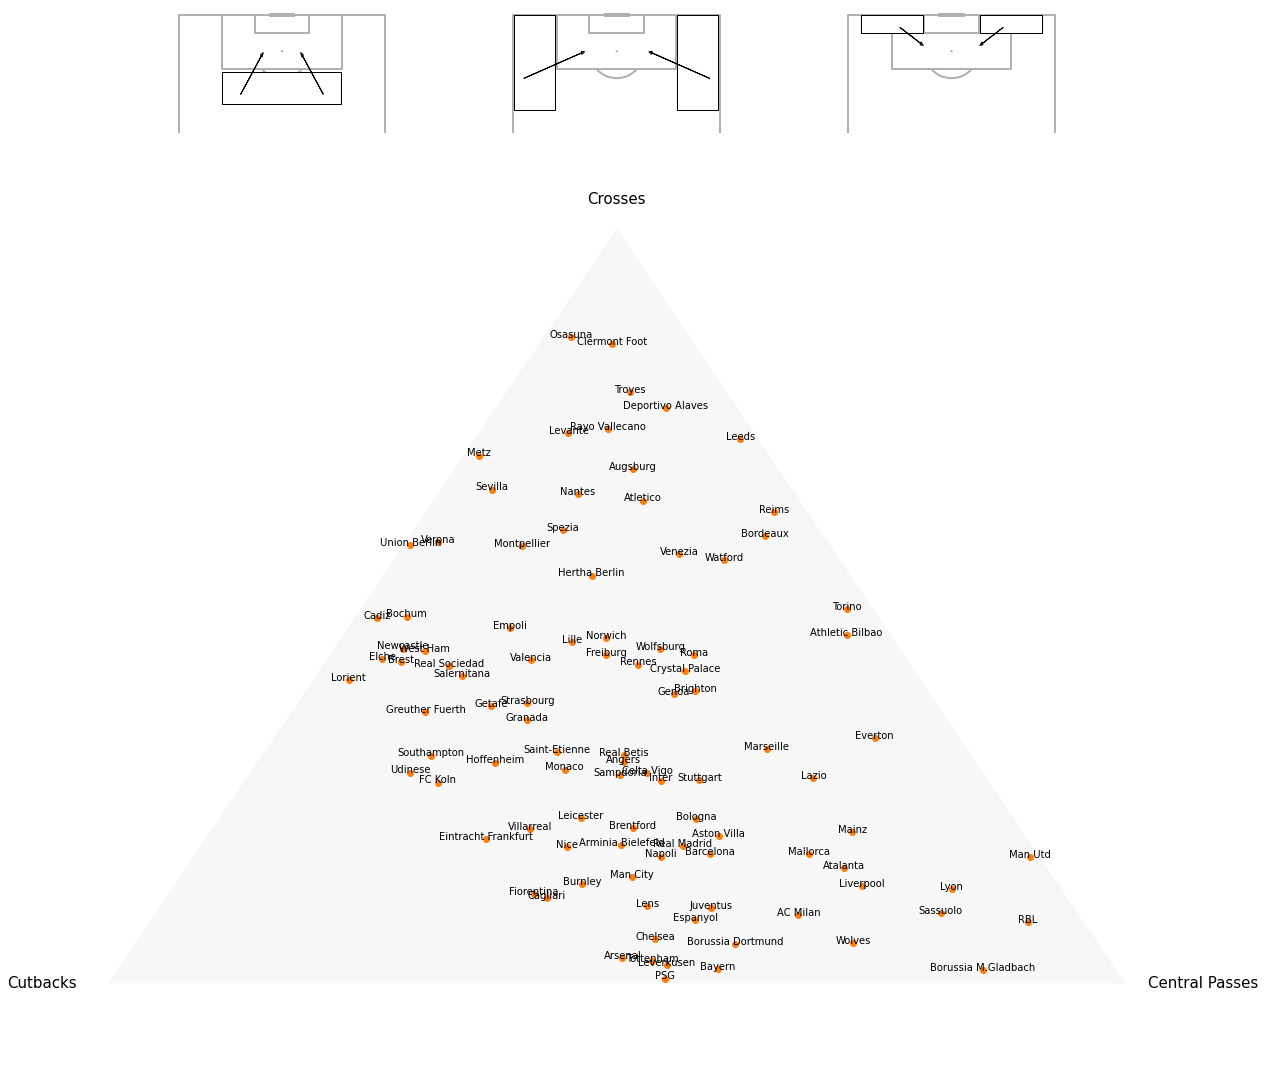

In [211]:
fig,ax = plt.subplots()
fig.set_size_inches(20,16)
ax0 = ax.inset_axes([0.1,1.05,0.2,0.2])
ax0 = draw_center(ax0)
ax1 = ax.inset_axes([0.4,1.05,0.2,0.2])
ax1 = draw_cross(ax1)
ax2 = ax.inset_axes([0.7,1.05,0.2,0.2])
ax2 = draw_cutback(ax2)
tax = ternary.TernaryAxesSubplot(ax=ax)
# tax.set_background_color(bg_color)
# tax.boundary(axes_colors=edge_color)
tax.scatter(final[['Central','Cross','Cutback']].values/100)
names = []
for i,txt in enumerate(to_label['team'].tolist()):
    x = ternary.project_point((to_label['Central'].iloc[i],to_label['Cross'].iloc[i],to_label['Cutback'].iloc[i]))[0]
    y = ternary.project_point((to_label['Central'].iloc[i],to_label['Cross'].iloc[i],to_label['Cutback'].iloc[i]))[1]
    names.append(plt.text(x/100,y/100,txt,ha='center',zorder =2 ))
tax.right_corner_label('Central Passes',position=(0.97,0.11),c=corner_color,fontsize= corner_size)
tax.top_corner_label('Crosses',offset=0.15,c=corner_color,fontsize= corner_size)
tax.left_corner_label('Cutbacks',position=(-0.07,0.11),c=corner_color,fontsize= corner_size)
# adjust_text(names,arrowprops=dict(arrowstyle="-", color='k', lw=0.5))
ax.axis('off')


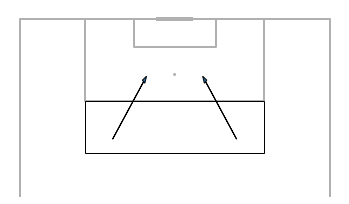

In [212]:
def draw_center(ax):
    pitch = VerticalPitch(half=True,pitch_type='opta',figsize=(20,20),pad_bottom=-20)  # for checking coordinates 
    pitch.draw(ax=ax)
    rect = patches.Rectangle((79,72),-57.8,11,facecolor='white',edgecolor='black')
    ax.add_patch(rect)
    ax.arrow(30,75,10,12,head_width = 1)
    ax.arrow(70,75,-10,12,head_width = 1)
    return ax
fig,ax = plt.subplots()
ax = draw_center(ax)